In [1]:
import yfinance as yf
import pandas as pd
from statsmodels.tsa.stattools import coint
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
import numpy as np

selected_etfs = ['IEMG', 'EEM', 'ARKK', 'ARKW', 'TLT', 'SPTL', 'SHY', 'VGSH', 'SOXX', 'ITA']

prices = yf.download(selected_etfs, start = '2015-01-01', end = '2024-12-31')['Close']

train_cutoff = pd.Timestamp("2020-01-01")

prices = prices.dropna()
all_pairs = [('IEMG', 'EEM'), ('ARKK', 'ARKW'), ('TLT', 'SPTL'), ('SHY', 'VGSH'),('SOXX', 'ITA')]

prices.info()


C:\Users\anair26\AppData\Local\Temp\ipykernel_31628\1138777958.py:17: FutureWarning: YF.download() has changed argument auto_adjust default to True
  prices = yf.download(selected_etfs, start = '2015-01-01', end = '2024-12-31')['Close']
[*********************100%***********************]  10 of 10 completed


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2515 entries, 2015-01-02 to 2024-12-30
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ARKK    2515 non-null   float64
 1   ARKW    2515 non-null   float64
 2   EEM     2515 non-null   float64
 3   IEMG    2515 non-null   float64
 4   ITA     2515 non-null   float64
 5   SHY     2515 non-null   float64
 6   SOXX    2515 non-null   float64
 7   SPTL    2515 non-null   float64
 8   TLT     2515 non-null   float64
 9   VGSH    2515 non-null   float64
dtypes: float64(10)
memory usage: 216.1 KB


In [2]:
def generate_labels(z, upper=1.5, lower=-1.5):
    return np.where(z > upper, -1,    # SHORT spread
           np.where(z < lower, 1,     # LONG spread
           0))                        # No trade

In [3]:
import pandas as pd
import statsmodels.api as sm

# Assumes `prices` is your DataFrame of adjusted-close prices,
# and `all_pairs` is a list of tuples: [(etf1, etf2), …]

lookback = 30
spread_records = []

for etf_a, etf_b in all_pairs:
    # Align prices and drop any NaNs for the pair
    pair_prices = pd.concat([prices[etf_a], prices[etf_b]], axis=1).dropna()
    a = pair_prices[etf_a]
    b = pair_prices[etf_b]

    # 1) Estimate hedge ratio via OLS
    model = sm.OLS(a, sm.add_constant(b)).fit()
    hedge_ratio = model.params[etf_b]

    # 2) Compute spread and rolling statistics
    spread = a - hedge_ratio * b
    rolling_mean = spread.rolling(window=lookback).mean()
    rolling_std = spread.rolling(window=lookback).std()
    z_score = (spread - rolling_mean) / rolling_std
    rolling_volatility = z_score.rolling(window=lookback).std()

    # 3) Build DataFrame for this pair
    df_pair = pd.DataFrame({
        'Date': spread.index,
        'pair': f"{etf_a}-{etf_b}",
        'spread': spread,
        'rolling_mean': rolling_mean,
        'rolling_std': rolling_std,
        'z_score': z_score,
        'rolling_volatility': rolling_volatility
    })

    spread_records.append(df_pair)

# Combine all pairs into a single long-form DataFrame
spread_long = pd.concat(spread_records, ignore_index=True)

# label feature
spread_long['label'] = generate_labels(spread_long['z_score'])

# 4) Add lagged features for z_score and spread
spread_long['z_score_lag1'] = spread_long.groupby('pair')['z_score'].shift(1)
spread_long['spread_lag1'] = spread_long.groupby('pair')['spread'].shift(1)

spread_long['z_score_lag2'] = spread_long.groupby('pair')['z_score'].shift(2)
spread_long['spread_lag2'] = spread_long.groupby('pair')['spread'].shift(2)

spread_long['z_score_lag3'] = spread_long.groupby('pair')['z_score'].shift(3)
spread_long['spread_lag3'] = spread_long.groupby('pair')['spread'].shift(3)


# 5) Final cleanup
spread_long.dropna(inplace=True)
spread_long.sort_values(['pair', 'Date'], inplace=True)
spread_long.reset_index(drop=True, inplace=True)

# `spread_long` now contains columns:
# ['Date', 'pair', 'spread', 'rolling_mean', 'rolling_std',
#  'z_score', 'rolling_volatility', 'z_score_lag1', 'spread_lag1']


spread_long.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12285 entries, 0 to 12284
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Date                12285 non-null  datetime64[ns]
 1   pair                12285 non-null  object        
 2   spread              12285 non-null  float64       
 3   rolling_mean        12285 non-null  float64       
 4   rolling_std         12285 non-null  float64       
 5   z_score             12285 non-null  float64       
 6   rolling_volatility  12285 non-null  float64       
 7   label               12285 non-null  int64         
 8   z_score_lag1        12285 non-null  float64       
 9   spread_lag1         12285 non-null  float64       
 10  z_score_lag2        12285 non-null  float64       
 11  spread_lag2         12285 non-null  float64       
 12  z_score_lag3        12285 non-null  float64       
 13  spread_lag3         12285 non-null  float64   

In [4]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split 


le_pairs = LabelEncoder()
spread_long['pair_encoded'] = le_pairs.fit_transform(spread_long['pair'])

print(spread_long['pair_encoded'])


0        0
1        0
2        0
3        0
4        0
        ..
12280    4
12281    4
12282    4
12283    4
12284    4
Name: pair_encoded, Length: 12285, dtype: int64


In [5]:
features = ['z_score_lag1', 'rolling_mean', 'z_score', 'z_score_lag3','z_score_lag2']
target = 'label'


train_spread_long = spread_long[spread_long['Date'] < train_cutoff]
test_spread_long = spread_long[spread_long['Date'] >= train_cutoff]

print(train_spread_long['Date'])


label_map = {-1: 0, 0: 1, 1: 2}

train_x = train_spread_long[features]
train_y = train_spread_long[target].map(label_map)

test_x = test_spread_long[features]
test_y = test_spread_long['label'].map(label_map)



0       2015-03-27
1       2015-03-30
2       2015-03-31
3       2015-04-01
4       2015-04-02
           ...    
11023   2019-12-24
11024   2019-12-26
11025   2019-12-27
11026   2019-12-30
11027   2019-12-31
Name: Date, Length: 6000, dtype: datetime64[ns]


In [ ]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
    
model = xgb.XGBClassifier(
    objective='multi:softprob',  # For multi-class (long, short, neutral)
    num_class=3,
    eval_metric='mlogloss',
    use_label_encoder=False
)

param_grid = {
    'n_estimators':    [50, 100, 200],
    'max_depth':       [3, 5, 7],
    'learning_rate':   [0.01, 0.1, 0.2],
    'subsample':       [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
}

grid = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring='accuracy',    # or your custom backtest metric
    cv=3,                  # e.g. 3-fold CV (use TimeSeriesSplit for time series)
    verbose=1,
    n_jobs=-1
)

grid.fit(train_x, train_y)

best_model = grid.best_estimator_
print("Best params:", grid.best_params_)
print("Best CV score:", grid.best_score_)

y_pred = best_model.predict(train_x)

inv_map = {v:k for k,v in label_map.items()}
y_pred_original = pd.Series(y_pred).map(inv_map)

from sklearn.metrics import classification_report

y_pred = best_model.predict(train_x)
print(classification_report(train_y, y_pred))


Fitting 3 folds for each of 243 candidates, totalling 729 fits
Best params: {'colsample_bytree': 0.6, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.6}
Best CV score: 0.9988333333333334
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       634
           1       1.00      1.00      1.00      4560
           2       1.00      0.99      0.99       806

    accuracy                           1.00      6000
   macro avg       1.00      1.00      1.00      6000
weighted avg       1.00      1.00      1.00      6000



c:\Users\anair26\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [15:43:12] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


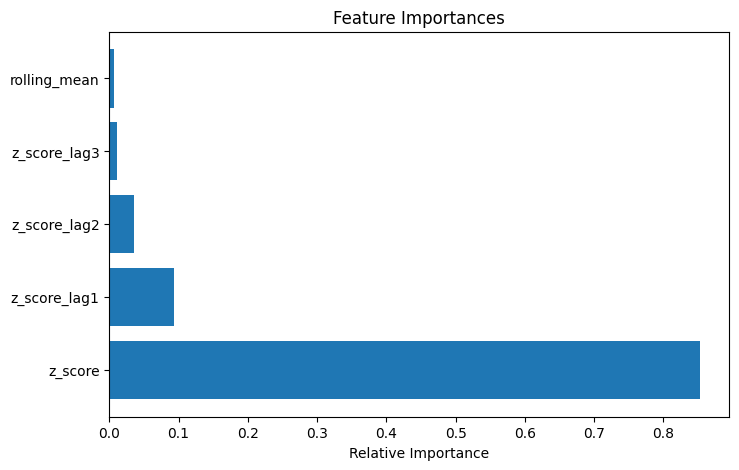

[0.00719382 0.01133596 0.03549507 0.09344723 0.8525279 ]


In [7]:
def feature_importance(Model,feature_df):

    fi = Model.feature_importances_
    feat_names = feature_df.columns

    # Create a sorted bar chart
    indices = np.argsort(fi)[::-1]
    plt.figure(figsize=(8,5))
    plt.barh(feat_names[indices], fi[indices])
    plt.title("Feature Importances")
    plt.xlabel("Relative Importance")
    plt.show()

    print(np.sort(fi))

feature_importance(best_model,train_x)

In [8]:
threshold_long = 0.6
threshold_short = 0.6
hold_period    = 5
initial_capital = 100  # per pair



In [9]:
import numpy as np

# ─────────────────────────────────────────────────────────────────────────────
# 0) PARAMETERS
hold_period     = 5      # how many days to hold any new +1/–1 signal
initial_capital = 100    # dollars per pair
# ─────────────────────────────────────────────────────────────────────────────

# 1) RAW MODEL SIGNAL
# ------------------------------------------------------------------
# best_model.predict returns array of {0,1,2} per your label_map:
#   0 ↔ original label -1 (short), 1 ↔ 0 (no‐trade), 2 ↔ 1 (long)
inv_map = {v:k for k,v in label_map.items()}  
raw_codes = best_model.predict(test_x)
# assign by position so we avoid any index errors:
test_spread_long['signal_raw'] = np.vectorize(inv_map.get)(raw_codes)



C:\Users\anair26\AppData\Local\Temp\ipykernel_31628\97206915.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_spread_long['signal_raw'] = np.vectorize(inv_map.get)(raw_codes)


In [10]:

# 2) HOLDING WINDOW
# ------------------------------------------------------------------
# Once you get a +1 or -1, forward‐fill it for `hold_period` days, per pair
test_spread_long['signal'] = (
    test_spread_long
      .groupby('pair')['signal_raw']
      .transform(lambda s: s.replace(0, np.nan).ffill(limit=hold_period))
      .fillna(0)
      .astype(int)
)

test_spread_long['spread_ret'] = (
    test_spread_long
      .groupby('pair')['spread']
      .transform(lambda x: x.pct_change().shift(-1))
)

test_spread_long

# t2 = test_spread_long.groupby('pair')['signal_raw'].apply(lambda s: s.replace(0, np.nan).ffill(limit=hold_period)).fillna(0).astype(int)

# t2

C:\Users\anair26\AppData\Local\Temp\ipykernel_31628\1546794504.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_spread_long['signal'] = (
C:\Users\anair26\AppData\Local\Temp\ipykernel_31628\1546794504.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_spread_long['spread_ret'] = (


,Date,pair,spread,rolling_mean,rolling_std,z_score,rolling_volatility,label,z_score_lag1,spread_lag1,z_score_lag2,spread_lag2,z_score_lag3,spread_lag3,pair_encoded,signal_raw,signal,spread_ret
1200,2020-01-02,ARKK-ARKW,5.941560,7.061692,0.381742,-2.934264,1.266779,1,-1.665175,6.432586,-1.952825,6.271109,-0.692034,6.728976,0,1,1,-0.028358
1201,2020-01-03,ARKK-ARKW,5.773071,7.026575,0.446996,-2.804284,1.383470,1,-2.934264,5.941560,-1.665175,6.432586,-1.952825,6.271109,0,1,1,-0.019281
1202,2020-01-06,ARKK-ARKW,5.661758,6.984499,0.511707,-2.584960,1.461822,1,-2.804284,5.773071,-2.934264,5.941560,-1.665175,6.432586,0,1,1,0.004202
1203,2020-01-07,ARKK-ARKW,5.685547,6.952461,0.561274,-2.257212,1.520194,1,-2.584960,5.661758,-2.804284,5.773071,-2.934264,5.941560,0,1,1,0.076465
1204,2020-01-08,ARKK-ARKW,6.120291,6.933530,0.579767,-1.402702,1.528858,0,-2.257212,5.685547,-2.584960,5.661758,-2.804284,5.773071,0,0,1,-0.025083
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12280,2024-12-23,TLT-SPTL,-7.425752,-7.289592,0.092689,-1.468994,0.973061,0,-1.459645,-7.415020,-2.286947,-7.477824,0.107162,-7.258487,4,0,1,-0.010472
12281,2024-12-24,TLT-SPTL,-7.347986,-7.295521,0.090446,-0.580078,0.932563,0,-1.468994,-7.425752,-1.459645,-7.415020,-2.286947,-7.477824,4,0,1,0.006662
12282,2024-12-26,TLT-SPTL,-7.396936,-7.303125,0.089004,-1.054019,0.895380,0,-0.580078,-7.347986,-1.468994,-7.425752,-1.459645,-7.415020,4,0,1,-0.005654
12283,2024-12-27,TLT-SPTL,-7.355111,-7.302673,0.088693,-0.591236,0.889817,0,-1.054019,-7.396936,-0.580078,-7.347986,-1.468994,-7.425752,4,0,1,0.018014


In [11]:
# # 3) NEXT-DAY SPREAD RETURN
# # ------------------------------------------------------------------
# # % change in your spread from t → t+1
# test_spread_long['spread_ret'] = (
#     test_spread_long['spread']
#       .pct_change()
#       .shift(-1)
# )



# # 4) DOLLAR P&L ON THE SPREAD
# # ------------------------------------------------------------------
# # Invest +$100 when signal=+1, –$100 when signal=–1
# test_spread_long['dollar_pnl'] = (
#     test_spread_long['signal'] * 
#     test_spread_long['spread_ret'] * 
#     initial_capital
# )
# 3) NEXT-DAY SPREAD DIFF (not pct-change)
test_spread_long['spread_diff'] = (
    test_spread_long['spread']
      .diff()      # spread_t – spread_{t-1}
      .shift(-1)   # align so that today’s signal applies to tomorrow’s move
)

# 4) DOLLAR P&L ON THE SPREAD (raw-change version)
# --------------------------------------------------------
# We want $100 notional per pair in the spread itself.
# That means we buy (or short) N = 100 / spread_t units of the spread.
# Then PnL = signal * (spread_{t+1} - spread_t) * N

test_spread_long['adjusted_spread'] = np.where(np.abs(test_spread_long['spread']) < 1,
                                 np.sign(test_spread_long['spread']) * 1,
                                 test_spread_long['spread'])

test_spread_long['position_size'] = initial_capital / test_spread_long['adjusted_spread']
test_spread_long['dollar_pnl'] = (
    test_spread_long['signal'] *
    test_spread_long['spread_diff'] *
    test_spread_long['position_size']
)



# test_spread_long['spread_diff'] = (
#     test_spread_long['spread'].diff().shift(-1)
# )

# test_spread_long['posi']

C:\Users\anair26\AppData\Local\Temp\ipykernel_31628\1639980662.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_spread_long['spread_diff'] = (
C:\Users\anair26\AppData\Local\Temp\ipykernel_31628\1639980662.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_spread_long['adjusted_spread'] = np.where(np.abs(test_spread_long['spread']) < 1,
C:\Users\anair26\AppData\Local\Temp\ipykernel_31628\1639980662.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFr

              spread  spread_diff
Date                             
2021-11-26  0.679258    -0.869348

Per-pair results:
             sharpe  cum_return
pair                           
ARKK-ARKW  0.433582   -1.000060
IEMG-EEM  -0.427621   -0.786932
SHY-VGSH   1.509720    0.766958
SOXX-ITA   0.214432   -0.483442
TLT-SPTL  -0.564665   -0.587354

Aggregate total return:      40.60%
Aggregate annualized Sharpe: 0.38


C:\Users\anair26\AppData\Local\Temp\ipykernel_31628\2007748618.py:47: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  pair_metrics = test_spread_long.groupby('pair').apply(pair_stats)


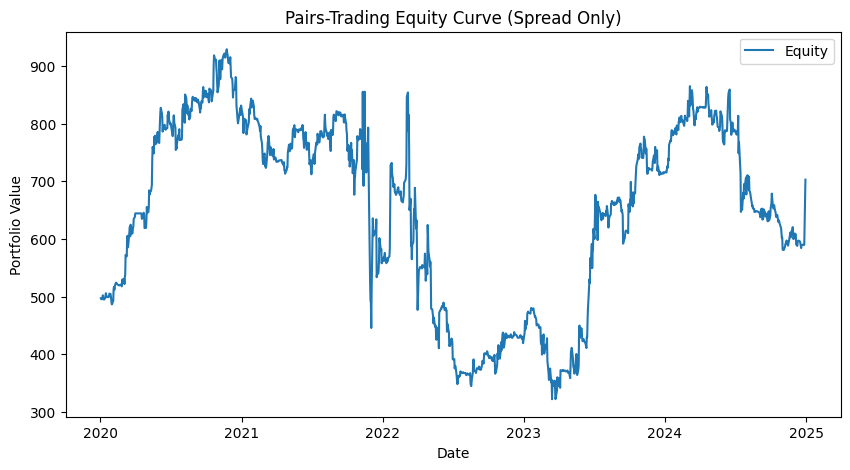

In [ ]:

# NEW sanity check: catch any single‐day P&L larger than your initial capital
max_loss = initial_capital * 2   # e.g. more than 2× your capital is impossible
if (test_spread_long['dollar_pnl'].abs() > max_loss).any():
    row = test_spread_long[test_spread_long['dollar_pnl'].abs() > max_loss].iloc[0]
    raise RuntimeError(f"Insane PnL on {row['Date']} pair={row['pair']}  PnL={row['dollar_pnl']}")

# 5) PER-PAIR PERFORMANCE  (unchanged)
def pair_stats(g):
    daily_pct = (g['dollar_pnl'] / initial_capital).dropna()
    if len(daily_pct) < 2:
        return pd.Series({'sharpe': np.nan, 'cum_return': np.nan})
    sharpe     = (daily_pct.mean() / daily_pct.std()) * np.sqrt(252)
    cum_return = (1 + daily_pct).prod() - 1
    return pd.Series({'sharpe': sharpe, 'cum_return': cum_return})

pair_metrics = test_spread_long.groupby('pair').apply(pair_stats)
print("\nPer-pair results:")
print(pair_metrics)

# 6) AGGREGATE METRICS & EQUITY CURVE  (unchanged)
daily_pnl = test_spread_long.groupby('Date')['dollar_pnl'].sum()
n_pairs   = test_spread_long['pair'].nunique()
total_cap = initial_capital * n_pairs
daily_pct  = daily_pnl / total_cap

equity     = (1 + daily_pct).cumprod() * total_cap
agg_sharpe = (daily_pct.mean() / daily_pct.std()) * np.sqrt(252)
agg_return = equity.iloc[-1]/total_cap - 1

print(f"\nAggregate total return:      {agg_return:.2%}")
print(f"Aggregate annualized Sharpe: {agg_sharpe:.2f}")

import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
plt.plot(equity.index, equity.values, label='Equity')
plt.title('Pairs-Trading Equity Curve (Spread Only)')
plt.xlabel('Date')
plt.ylabel('Portfolio Value')
plt.legend()
plt.show()



In [ ]:
# except Exception as e:
#     print("❗ Failed assigning signal")
#     print("df.shape =", df.shape)
#     print("df.index[:5] =", df.index[:5])
#     print("series.shape =", some_series.shape)
#     print("series.index[:5] =", some_series.index[:5])
#     raise

SyntaxError: invalid syntax (1272850804.py, line 1)